✅ Step 1: Load the coordinates and cluster labels

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Paths
project_root = Path("..").resolve()
coord_path = project_root / "data/patches/sst_patch_coords.npy"
coords = np.load(coord_path)  # shape: (N, 2) → [lat, lon]
print("✅ Coordinates shape:", coords.shape)

# Optional: Load UMAP embeddings to re-run DBSCAN
N = np.load(project_root / "data/patches/sst_patch_coords.npy").shape[0]
embeddings = np.load(project_root / "outputs/sst_umap_embeddings.npy")[:N]

# Run DBSCAN again (or load saved labels if you have them)
from sklearn.cluster import DBSCAN
labels = DBSCAN(eps=0.5, min_samples=10).fit_predict(embeddings)

# Filter out DBSCAN noise points
mask = labels != -1
labels = labels[mask]
coords = coords[mask]

print("✅ Loaded labels:", np.unique(labels))

✅ Coordinates shape: (2399, 2)
✅ Loaded labels: [0 1 2 3]


🗺️ Step 2: Plot clusters on a world map

/tmp/ipykernel_382237/2224260374.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap     = get_cmap('tab10')            # qualitative palette


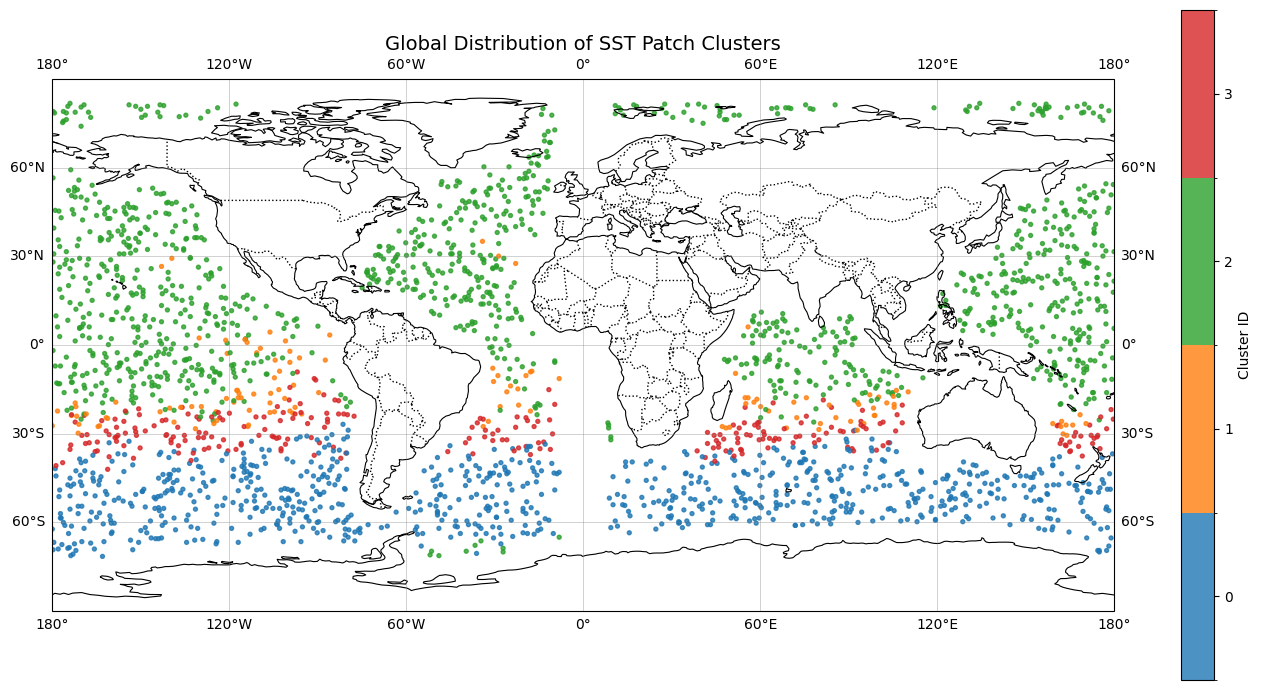

In [19]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap
from matplotlib.colors import ListedColormap, BoundaryNorm

# ── Set up map ─────────────────────────────────────────────────────────────
fig = plt.figure(figsize=(14, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines(resolution='110m', linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)

# ── Discrete colormap that matches the exact cluster count ────────────────
unique_labels = sorted(set(labels))          # e.g. [0, 1, 2, 3]
base_cmap     = get_cmap('tab10')            # qualitative palette
custom_cmap   = ListedColormap(base_cmap.colors[:len(unique_labels)])

# Create a normalizer that centers colors on integer cluster IDs
bounds = np.arange(len(unique_labels) + 1) - 0.5      # [-0.5, 0.5, 1.5, ...]
norm   = BoundaryNorm(bounds, custom_cmap.N)

# ── Scatter plot ───────────────────────────────────────────────────────────
scatter = ax.scatter(
    coords[:, 1],              # longitude
    coords[:, 0],              # latitude
    c=labels,                  # discrete cluster labels
    cmap=custom_cmap,
    norm=norm,                 # guarantees one color per label
    s=8,
    alpha=0.8,
    transform=ccrs.PlateCarree()
)

# ── Discrete colorbar with integer ticks only ─────────────────────────────
cbar = plt.colorbar(
    scatter,
    ax=ax,
    orientation='vertical',
    ticks=unique_labels              # show 0,1,2,3 only
)
cbar.set_label("Cluster ID")

# ── Final touches & save ───────────────────────────────────────────────────
plt.title("Global Distribution of SST Patch Clusters", fontsize=14)
plt.tight_layout()
plt.savefig(
    project_root / "results" / "figures" / "Global_Distribution_of_SST_Patch_Clusters.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()